In [1]:
import pyodbc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [20]:
# Connect to the Database
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                        "Server=wd02;"
                        "Database=FootPrint;"
                        "Trusted_Connection=yes;")

# QUERY 01: Operations

In [3]:
df = pd.read_sql_query("DECLARE @from date, @to date;\
    SELECT\
        @from = getdate()\
        ,@to = dateadd(day, 1, getdate());\
\
SELECT CONVERT(varchar,t.completedDateTime,100) Date, w.name warehouse, p.name project, oc.name operationCode, t.employee\
    FROM datex_footprint.Tasks t\
    JOIN datex_footprint.OperationCodes oc\
        ON oc.id = t.operationCodeId\
    JOIN datex_footprint.Warehouses w\
        ON w.id = t.warehouseId\
    JOIN datex_footprint.Projects p\
        ON p.id = t.projectId\
    WHERE t.completedDateTime >= @from AND t.completedDateTime < @to AND (t.employee != 'FootPrintService') AND (t.employee != 'Foot Print Service') and t.statusId = 2", cnxn)

In [4]:
# Adding Hours
df['Hour'] = pd.to_datetime(df['Date']).dt.hour
df.head()

,Date,warehouse,project,operationCode,employee,Hour
0,Apr 19 2022 7:53AM,20,"ACI Healthcare USA, Inc.",Scanned Shipment,Gregory Watts,7
1,Apr 19 2022 7:55AM,20,"Exact-Rx, Inc.",Scanned Shipment,Wendy Medrano,7
2,Apr 19 2022 7:58AM,20,"ACI Healthcare USA, Inc.",Scanned Shipment,Micah Powers,7
3,Apr 19 2022 8:11AM,10,"Methapharm, Inc.",Scanned Shipment,Hugo Gonzales,8
4,Apr 19 2022 8:13AM,20,"ACI Healthcare USA, Inc.",Scanned Shipment,Gregory Watts,8


# WAREHOUSE

In [5]:
# Group By Warehouse
df_warehouse = df.groupby(['warehouse']).count()[['operationCode']]
df_warehouse.reset_index(inplace=True)
df_warehouse.head()

,warehouse,operationCode
0,10,104
1,16,20
2,18,25
3,19,1
4,20,297


In [6]:
# Pie Chart
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

#plt.subplots(figsize=(8,8))
#plt.pie(activity, labels=warehouse)
#plt.show()

In [7]:
# Bar Chart
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

#plt.subplots(figsize=(8,8))
#plt.bar(warehouse, activity)
#plt.show()

In [8]:
# Save Data in JSON format
df_warehouse_index = df_warehouse.set_index(['warehouse'])
df_warehouse_index.to_json('data/warehouse.json')
df_warehouse_index.head()

,operationCode
warehouse,
10,104
16,20
18,25
19,1
20,297


### All Operations type

In [9]:
df_operation = df.groupby(['operationCode']).count()[['project']]
df_operation.reset_index(inplace=True)
df_operation.head()

,operationCode,project
0,Batch Move,12
1,Count,32
2,Create Inventory,1
3,DRIVER CHECK IN,1
4,Finished Receiving,1


In [10]:
# Horizontal Bar Chart
values = df_operation['project']
operation = df_operation['operationCode']

#plt.subplots(figsize=(8,8))
#plt.barh(operation, values)
#plt.gca().invert_yaxis()
#plt.show()

In [11]:
df_operation.rename(columns={"project": "Tasks"})
df_operation.head()

,operationCode,project
0,Batch Move,12
1,Count,32
2,Create Inventory,1
3,DRIVER CHECK IN,1
4,Finished Receiving,1


In [12]:
# Save Data in JSON format
df_operation = df_operation.rename(columns={"project": "Tasks"})
df_operation_index = df_operation.set_index(['operationCode'])
df_operation_index.to_json('data/operations_type.json')
df_operation_index.head()

,Tasks
operationCode,
Batch Move,12
Count,32
Create Inventory,1
DRIVER CHECK IN,1
Finished Receiving,1


### Excluding Operations PICKING and RECEIVING

In [13]:
df_operation_excluded = df_operation.loc[(df_operation["operationCode"] != 'Picking') &
                                         (df_operation["operationCode"] != 'Receiving')]

In [14]:
# Save Data in JSON format
df_operation_excluded = df_operation_excluded.rename(columns={"project": "Tasks"})
df_operation_excluded_index = df_operation_excluded.set_index(['operationCode'])
df_operation_excluded_index.to_json('data/operations_type_excluded.json')
df_operation_excluded_index.head()

,Tasks
operationCode,
Batch Move,12
Count,32
Create Inventory,1
DRIVER CHECK IN,1
Finished Receiving,1


### Operations per Hour

In [15]:
df_hours = df.groupby(['Hour']).count()[['operationCode']]
df_hours.reset_index(inplace=True)
df_hours.head()

,Hour,operationCode
0,6,9
1,7,94
2,8,393


In [16]:
# Bar Chart
hour = df_hours['Hour']
activity = df_hours['operationCode']

#plt.subplots(figsize=(8,8))
#plt.bar(hour, activity)
#plt.xticks(hour)
#plt.show()

In [17]:
df_hours = df_hours.rename(columns={'operationCode': 'Operations'})
df_hours_index = df_hours.set_index(['Hour'])
df_hours_index.to_json('data/hours.json')
df_hours_index.head()

,Operations
Hour,
6,9
7,94
8,393


# PICKING

In [18]:
# Filtered by Picking
df_picking = df[df['operationCode'] == 'Picking']

In [19]:
# Grouped by Employee and Hour
df_picking_grouped = df_picking.groupby(['employee', 'Hour']).count()[['operationCode']]
df_picking_grouped.reset_index(inplace=True)
df_picking_grouped.head()

,employee,Hour,operationCode
0,Aisha Cooper,7,5
1,Aisha Cooper,8,19
2,Carlos Gomez,8,6
3,Edilberto Souza,8,5
4,Ernest Ferguson,8,18


In [20]:
# Pivot
df_picking_pivoted = df_picking_grouped.pivot(index='employee', columns='Hour', values='operationCode')
df_picking_pivoted = df_picking_pivoted.fillna(0)
df_picking_pivoted = df_picking_pivoted.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

df_picking_pivoted.head()

,6,7,8
employee,,,
Aisha Cooper,0.0,5.0,19.0
Carlos Gomez,0.0,0.0,6.0
Edilberto Souza,0.0,0.0,5.0
Ernest Ferguson,0.0,0.0,18.0
Gregory Watts,0.0,2.0,6.0


### Save in JSON File

In [21]:
# Save into JSON
pickers = df_picking_pivoted.T
pickers.to_json('data/pickers.json')
pickers.head()

employee,Aisha Cooper,Carlos Gomez,Edilberto Souza,Ernest Ferguson,Gregory Watts,Hugo Gonzales,Maria Ramos,Micah Powers,Nelson Hurtado,Shawn Saunders,Wendy Medrano,William Trevino Trevino
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
7,5.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,9.0,1.0,8.0
8,19.0,6.0,5.0,18.0,6.0,24.0,74.0,5.0,9.0,10.0,24.0,0.0


### Picking By Warehouse Function

In [22]:
# Picking Function
def picking_by_warehouse (warehouse):
    # Filter by warehouse
    df_w = df_picking[df_picking['warehouse'] == warehouse]
    
    # Grouped by Employee and Hour
    df_w_group = df_w.groupby(['employee', 'Hour']).count()[['operationCode']]
    df_w_group.reset_index(inplace=True)
    
    # Pivot
    df_w_pivot = df_w_group.pivot(index='employee', columns='Hour', values='operationCode')
    df_w_pivot = df_w_pivot.fillna(0)
    df_w_pivot = df_w_pivot.rename_axis(None, axis=1)
    
    # Save into JSON
    pickers_df = df_w_pivot.T
    file_name = f'data/pickers_w{warehouse}.json'
    pickers_df.to_json(file_name)

In [23]:
# Save warehouse data into JSON files
picking_by_warehouse('10')
picking_by_warehouse('12')
picking_by_warehouse('15')
picking_by_warehouse('16')
picking_by_warehouse('18')
picking_by_warehouse('19')
picking_by_warehouse('20')
picking_by_warehouse('21')
picking_by_warehouse('22')

# RECEIVING

In [24]:
# Filtered by Picking
receiving_df = df[df['operationCode'] == 'Receiving']
receiving_df.head()

,Date,warehouse,project,operationCode,employee,Hour
367,Apr 19 2022 7:23AM,22,"NBTY Global, Inc.",Receiving,Chris Martin,7
368,Apr 19 2022 7:23AM,22,"NBTY Global, Inc.",Receiving,Chris Martin,7
369,Apr 19 2022 7:23AM,22,"NBTY Global, Inc.",Receiving,Chris Martin,7
370,Apr 19 2022 7:23AM,22,"NBTY Global, Inc.",Receiving,Chris Martin,7
371,Apr 19 2022 7:23AM,22,"NBTY Global, Inc.",Receiving,Chris Martin,7


In [25]:
# Grouped by Employee and Hour
receiving_group_df = receiving_df.groupby(['employee', 'Hour']).count()[['operationCode']]
receiving_group_df.reset_index(inplace=True)
receiving_group_df.head()

,employee,Hour,operationCode
0,Chris Martin,7,14
1,Juan Castro,7,19


In [26]:
# Pivot
receiving_pivot_df = receiving_group_df.pivot(index='employee', columns='Hour', values='operationCode')
receiving_pivot_df = receiving_pivot_df.fillna(0)
receiving_pivot_df = receiving_pivot_df.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

receiving_pivot_df.head()

,7
employee,
Chris Martin,14
Juan Castro,19


In [27]:
# Save into JSON
receivers = receiving_pivot_df.T
receivers.to_json('data/receivers.json')
receivers.head()

employee,Chris Martin,Juan Castro
7,14,19


# INVENTORY

In [28]:
# Group By Operation Code and Warehouse
cycle_count_df = df.groupby(['operationCode', 'warehouse']).count()[['employee']]
cycle_count_df.reset_index(inplace=True)

In [29]:
# Filtering by Count, Recount and Inventory Adjustment
cc_df = cycle_count_df.loc[(cycle_count_df["operationCode"] == 'Count') |
                           (cycle_count_df["operationCode"] == 'Recount') |
                           (cycle_count_df["operationCode"] == 'Inventory Adjustment')]

cc_df = cc_df.rename(columns={'employee': 'count'})

In [30]:
cc_df_pivot = cc_df.pivot(index='operationCode', columns='warehouse', values='count')

In [31]:
try:
    cc_df_pivot.rename({'Count': 'Inventory Counts'}, axis='index', inplace=True)
except:
    print('Operation COUNT does not exist yet')
    
try:
    cc_df_pivot.rename({'Recount': 'Discrepancies'}, axis='index', inplace=True)
except:
    print('Operation DISCREPANCIES does not exist yet')
    
try:
    cc_df_pivot.rename({'Inventory Adjustment': 'Inventory Adjustments'}, axis='index', inplace=True)
except:
    print('Operation INVENTORY ADJUSTMENT does not exist yet')

In [32]:
cc_df_pivot = cc_df_pivot.fillna(0)
cc_df_pivot.to_json('data/cycle_count.json')
cc_df_pivot.head()

warehouse,10,20,22
operationCode,,,
Inventory Counts,10.0,22.0,0.0
Inventory Adjustments,1.0,0.0,15.0
Discrepancies,0.0,2.0,0.0


# QUERY 02: Open Outbounds

In [33]:
df_02 = pd.read_sql_query("SELECT DISTINCT w.name warehouse, p.name project, s.lookupCode shipment_number, s.createdSysDateTime\
    FROM datex_footprint.shipments s\
    LEFT JOIN datex_footprint.ShipmentOrderLookup sol\
        on sol.shipmentId = s.id\
    LEFT JOIN datex_footprint.orders o\
        on o.id = sol.orderId\
    LEFT JOIN datex_footprint.Projects p\
        on p.id = o.projectId\
    LEFT JOIN datex_footprint.warehouses w\
        on w.id = isnull(s.actualWarehouseId, s.expectedWarehouseId)\
    WHERE s.statusId in (1, 2, 4) and s.typeId = 2\
    ORDER BY createdSysDateTime", cnxn)

In [34]:
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447


In [35]:
df_02['age_order'] = pd.Timestamp.now() - df_02['createdSysDateTime']
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime,age_order
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1727 days 23:40:13.288140
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,931 days 21:59:12.342140
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,886 days 16:12:37.692140
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,817 days 19:29:09.422140
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,817 days 19:29:09.038140


In [36]:
df_02['age_order_days'] = df_02['age_order'].dt.components['days']
df_02['age_order_hours'] = df_02['age_order'].dt.components['hours']
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime,age_order,age_order_days,age_order_hours
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1727 days 23:40:13.288140,1727,23
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,931 days 21:59:12.342140,931,21
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,886 days 16:12:37.692140,886,16
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,817 days 19:29:09.422140,817,19
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,817 days 19:29:09.038140,817,19


In [37]:
bins =[-1,1,2,3,7,30,60, 90,365, 730,10000]
bin_names = ['24 Hours', '48 Hours', '72 Hours', '1 Week', '1 Month', '2 Months', '3 Months', '1 Year', '2 Years', 'More than 2 years']

df_02['age_group'] = pd.cut(df_02['age_order_days'], bins, labels=bin_names)

In [38]:
df_02_grouped = df_02.groupby(['age_group'])[['project']].count()

In [39]:
df_02_grouped = df_02_grouped.rename(columns={'project': 'orders'})

In [40]:
df_02_grouped

,orders
age_group,
24 Hours,765
48 Hours,11
72 Hours,65
1 Week,335
1 Month,895
2 Months,681
3 Months,512
1 Year,1893
2 Years,1092


### Save in JSON File

In [41]:
open_outbounds = df_02_grouped
open_outbounds.to_json('data/open_outbounds.json')
open_outbounds

,orders
age_group,
24 Hours,765
48 Hours,11
72 Hours,65
1 Week,335
1 Month,895
2 Months,681
3 Months,512
1 Year,1893
2 Years,1092


<AxesSubplot:ylabel='age_group'>

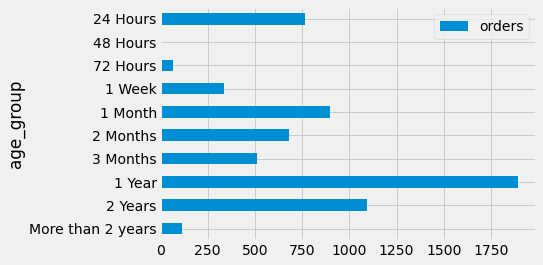

In [42]:
df_02_grouped = df_02_grouped.iloc[::-1]
df_02_grouped.plot.barh()

# QUERY 3: Picking Performance (Orders and Waves)

In [ ]:
# SELECT @from = getdate(), @to = dateadd(day, 1, getdate());\

In [26]:
df03 = pd.read_sql_query("DECLARE @from date, @to date;\
                          SELECT @from = '2022-04-01', @to = '2022-04-23';\
    SELECT t.completedDateTime Date, oc.name Operation, w.name Warehouse,\
           p.name Project, m.lookupCode Material, employee Employee, s.lookupCode Shipment, isnull(s.waveId, ps.waveId) Wave,\
           ordersPerWave.shipmentsCount, lc.name Location, o.orderClassId\
    FROM datex_footprint.Tasks t\
        join datex_footprint.OperationCodes oc\
            on oc.id = t.operationCodeId\
        left join datex_footprint.Warehouses w\
            on w.id = t.warehouseId\
        left join datex_footprint.Projects p\
            on p.id = t.projectId\
        left join datex_footprint.Materials m\
            on m.id = t.materialId\
        left join datex_footprint.Shipments s\
        inner join datex_footprint.ShipmentOrderLookup sol\
        inner join datex_footprint.orders o\
            on o.id = sol.orderId\
            on sol.shipmentId = s.id\
            on s.id = t.shipmentId\
        left join datex_footprint.PickSlips ps\
            on ps.id = t.pickSlipId\
        left join datex_footprint.LocationContainers lc\
            on lc.id = t.actualSourceLocationId\
        outer apply (\
            select\
                count(distinct tt.shipmentId) shipmentsCount\
                from datex_footprint.waves ww\
                    inner join datex_footprint.PickSlips ppss\
                    inner join datex_footprint.tasks tt\
                        on tt.operationCodeId = 8 and tt.pickSlipId = ppss.id\
                        on ppss.waveId = ww.id\
                where ww.id = isnull(s.waveId, ps.waveId)) ordersPerWave\
    where t.completedDateTime >= @from and t.completedDateTime < @to and t.statusId = 2 and isnull(o.orderClassId, 0) not in (23, 24, 36) and s.lookupCode not like '%TEST%'\
    and t.operationCodeId in (8, 39, 2064, 2065, 2066, 2067, 2068) and t.employee != 'Foot Print Service'\
    order by s.lookupCode, t.completedDateTime", cnxn)

In [27]:
df03.tail(3)

,Date,Operation,Warehouse,Project,Material,Employee,Shipment,Wave,shipmentsCount,Location,orderClassId
51703,2022-04-05 10:36:30.120,Picking,19,"Zymergen, Inc.",FXP-1201,Brad Bacchetti,ZYM4522,233212.0,1,19-Receiving,2
51704,2022-04-05 10:36:39.680,Picking,19,"Zymergen, Inc.",FXP-1201,Brad Bacchetti,ZYM4522,233212.0,1,19-Receiving,2
51705,2022-04-05 10:37:09.680,Picking Completed,19,"Zymergen, Inc.",None,Brad Bacchetti,ZYM4522,233212.0,1,None,2


In [28]:
# Order Columns
df03 = df03[['Warehouse', 'Project', 'Wave', 'Shipment', 'Date', 'Operation', 'Employee',
             'Location', 'shipmentsCount', 'Material']]

### Filter by Shipments

In [29]:
# Filter by Orders only
df03_orders = df03.loc[(df03['Operation']=='Picking') |
                       (df03['Operation']=='Scanned Shipment') |
                       (df03['Operation']=='Picking Completed')]

df03_orders = df03_orders[['Warehouse', 'Project', 'Shipment', 'Date', 'Operation', 'Employee', 'Location']]

df03_orders.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location
0,10,Emerginnova,Eme-2-99306,2022-04-21 17:36:34.967,Scanned Shipment,Carlos Gomez,None
1,10,Emerginnova,Eme-2-99306,2022-04-21 17:37:20.000,Picking,Carlos Gomez,04-08-04-04
2,10,Emerginnova,Eme-2-99306,2022-04-21 17:38:02.983,Picking Completed,Carlos Gomez,None
4,10,ISDIN Corporation,0085553655,2022-04-07 11:13:19.077,Scanned Shipment,Hugo Gonzales,None
5,10,ISDIN Corporation,0085553655,2022-04-07 11:14:23.120,Picking,Hugo Gonzales,34-02-01-B


In [30]:
# Create a new column with the time difference between rows
df03_orders['PickingTime'] = df03_orders['Date'].diff()
df03_orders.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime
0,10,Emerginnova,Eme-2-99306,2022-04-21 17:36:34.967,Scanned Shipment,Carlos Gomez,None,NaT
1,10,Emerginnova,Eme-2-99306,2022-04-21 17:37:20.000,Picking,Carlos Gomez,04-08-04-04,0 days 00:00:45.033000
2,10,Emerginnova,Eme-2-99306,2022-04-21 17:38:02.983,Picking Completed,Carlos Gomez,None,0 days 00:00:42.983000
4,10,ISDIN Corporation,0085553655,2022-04-07 11:13:19.077,Scanned Shipment,Hugo Gonzales,None,-15 days +17:35:16.094000
5,10,ISDIN Corporation,0085553655,2022-04-07 11:14:23.120,Picking,Hugo Gonzales,34-02-01-B,0 days 00:01:04.043000


In [31]:
# Add Hour, Minute and Second columns
df03_orders['hour'] = df03_orders['PickingTime'].dt.components['hours']
df03_orders['minute'] = df03_orders['PickingTime'].dt.components['minutes']
df03_orders['second'] = df03_orders['PickingTime'].dt.components['seconds']
df03_orders.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second
0,10,Emerginnova,Eme-2-99306,2022-04-21 17:36:34.967,Scanned Shipment,Carlos Gomez,None,NaT,NaN,NaN,NaN
1,10,Emerginnova,Eme-2-99306,2022-04-21 17:37:20.000,Picking,Carlos Gomez,04-08-04-04,0 days 00:00:45.033000,0.0,0.0,45.0
2,10,Emerginnova,Eme-2-99306,2022-04-21 17:38:02.983,Picking Completed,Carlos Gomez,None,0 days 00:00:42.983000,0.0,0.0,42.0
4,10,ISDIN Corporation,0085553655,2022-04-07 11:13:19.077,Scanned Shipment,Hugo Gonzales,None,-15 days +17:35:16.094000,17.0,35.0,16.0
5,10,ISDIN Corporation,0085553655,2022-04-07 11:14:23.120,Picking,Hugo Gonzales,34-02-01-B,0 days 00:01:04.043000,0.0,1.0,4.0


In [32]:
# Set all the Scanned Shipment hour, minute, time to ZERO
df03_orders_modified = df03_orders

df03_orders_modified.loc[df03_orders_modified.Operation == 'Scanned Shipment', 'hour'] = 0.0
df03_orders_modified.loc[df03_orders_modified.Operation == 'Scanned Shipment', 'minute'] = 0.0
df03_orders_modified.loc[df03_orders_modified.Operation == 'Scanned Shipment', 'second'] = 0.0

df03_orders_modified.loc[df03_orders_modified['Operation'] == 'Scanned Shipment'].head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second
0,10,Emerginnova,Eme-2-99306,2022-04-21 17:36:34.967,Scanned Shipment,Carlos Gomez,None,NaT,0.0,0.0,0.0
4,10,ISDIN Corporation,0085553655,2022-04-07 11:13:19.077,Scanned Shipment,Hugo Gonzales,None,-15 days +17:35:16.094000,0.0,0.0,0.0
9,10,ISDIN Corporation,0085553656,2022-04-07 11:23:50.963,Scanned Shipment,Hugo Gonzales,None,0 days 00:07:51.886000,0.0,0.0,0.0
16,10,ISDIN Corporation,0085557917,2022-04-20 15:48:24.147,Scanned Shipment,Edilberto Souza,None,13 days 04:17:47.124000,0.0,0.0,0.0
34,10,ISDIN Corporation,0085558145,2022-04-21 19:09:38.180,Scanned Shipment,Liliana Puentes,None,1 days 03:19:40.357000,0.0,0.0,0.0


In [33]:
df03_orders_modified['Time'] = df03_orders_modified['hour']*60 + df03_orders_modified['minute'] + df03_orders_modified['second']/60
df03_orders_modified.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second,Time
0,10,Emerginnova,Eme-2-99306,2022-04-21 17:36:34.967,Scanned Shipment,Carlos Gomez,None,NaT,0.0,0.0,0.0,0.000000
1,10,Emerginnova,Eme-2-99306,2022-04-21 17:37:20.000,Picking,Carlos Gomez,04-08-04-04,0 days 00:00:45.033000,0.0,0.0,45.0,0.750000
2,10,Emerginnova,Eme-2-99306,2022-04-21 17:38:02.983,Picking Completed,Carlos Gomez,None,0 days 00:00:42.983000,0.0,0.0,42.0,0.700000
4,10,ISDIN Corporation,0085553655,2022-04-07 11:13:19.077,Scanned Shipment,Hugo Gonzales,None,-15 days +17:35:16.094000,0.0,0.0,0.0,0.000000
5,10,ISDIN Corporation,0085553655,2022-04-07 11:14:23.120,Picking,Hugo Gonzales,34-02-01-B,0 days 00:01:04.043000,0.0,1.0,4.0,1.066667


In [34]:
# Save in JSON Format for HTML
df03_group = df03_orders_modified.groupby(['Warehouse', 'Project', 'Shipment', 'Operation', 'Date'])[['Time']].sum().sort_values(['Warehouse', 'Project', 'Shipment', 'Date'])
df03_group.to_json('data/performance.json', orient='table')
df03_group.head(20)

Time
Warehouse Project                  Shipment         Operation         Date                             
10        ACI Healthcare USA, Inc. 7785542-FL-BO-FL Scanned Shipment  2022-04-06 09:34:59.940  0.000000
                                                    Picking           2022-04-06 09:43:07.943  8.133333
                                                                      2022-04-06 09:43:49.570  0.683333
                                                                      2022-04-06 09:44:21.257  0.516667
                                                                      2022-04-06 09:45:10.900  0.816667
                                                                      2022-04-06 09:46:01.887  0.833333
                                                    Picking Completed 2022-04-06 09:46:31.887  0.500000
                                   7812161-FL       Scanned Shipment  2022-04-06 09:25:57.173  0.000000
                                                    Picking           2022-04-06 09:26:09.317  0.200000
                                   7812162-FL       Scanned Shipment  2022-04-06 09:18:57.100  0.000000
                                                    Picking           2022-04-06 09:20:58.683  2.016667
                                                                      2022-04-06 09:22:42.187  1.716667
                                   7812164-FL       Scanned Shipment  2022-04-06 09:23:58.640  0.000000
                                                    Picking           2022-04-06 09:24:16.173  0.283333
                                   7812383-FLS      Scanned Shipment  2022-04-05 11:14:04.080  0.000000
                                                    Picking           2022-04-05 11:14:20.817  0.266667
                                                                      2022-04-05 11:14:44.253  0.383333
                                                                      2022-04-05 11:14:55.550  0.183333
                                   7813082-FL       Scanned Shipment  2022-04-06 09:25:10.063  0.000000
                                                    Picking           2022-04-06 09:25:26.190  0.266667

In [38]:
# Remove Operation 'Scanned Shipment' and 'Picking Completed'
df03_excluding_Scanned = df03_orders_modified.loc[(df03_orders_modified['Operation'] != 'Scanned Shipment') &
                                                  (df03_orders_modified['Operation'] != 'Picking Completed')]
df03_excluding_Scanned.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second,Time
1,10,Emerginnova,Eme-2-99306,2022-04-21 17:37:20.000,Picking,Carlos Gomez,04-08-04-04,0 days 00:00:45.033000,0.0,0.0,45.0,0.750000
5,10,ISDIN Corporation,0085553655,2022-04-07 11:14:23.120,Picking,Hugo Gonzales,34-02-01-B,0 days 00:01:04.043000,0.0,1.0,4.0,1.066667
6,10,ISDIN Corporation,0085553655,2022-04-07 11:15:29.077,Picking,Hugo Gonzales,Aisle-33,0 days 00:01:05.957000,0.0,1.0,5.0,1.083333
10,10,ISDIN Corporation,0085553656,2022-04-07 11:24:59.983,Picking,Hugo Gonzales,33-08-01-A,0 days 00:01:09.020000,0.0,1.0,9.0,1.150000
11,10,ISDIN Corporation,0085553656,2022-04-07 11:25:49.640,Picking,Hugo Gonzales,33-05-01-B,0 days 00:00:49.657000,0.0,0.0,49.0,0.816667


In [63]:
# Group Employees into Roles

df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Aisha Cooper','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Alejandro Aguirre','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Andre Jocelin','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Andre Nau','Role'] = 'Technician'

df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Angel Luna','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Angela Briceno','Role'] = 'Coordinator'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Angela Pena','Role'] = 'Coordinator'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Baldomero Ramos','Role'] = 'Coordinator'


df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Brad Bacchetti','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Carl Ambroise','Role'] = 'IT'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Carlos Chavez','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Carlos Gomez','Role'] = 'Technician'

df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Carly Potts','Role'] = 'Coordinator'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Dan Parisi','Role'] = 'Coordinator'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Danielle Lucas','Role'] = 'Coordinator'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Diana Martinez','Role'] = 'Technician'

df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Diego Londono','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Djenyson Sanon','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Doris Hernandez','Role'] = 'Coordinator'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Doris Hincapie','Role'] = 'Technician'

df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Edilberto Souza','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Edwin Perez','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Ernest Ferguson','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Felix Blanco','Role'] = 'Coordinator'

df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Frantz Laman','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Gonzalo Guzman','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Gregory Watts','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Haydee Moreno','Role'] = 'Technician'

df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Hector Gonzalez','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Hugo Gonzales','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Isaiah Lyng','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Jackson Pierre','Role'] = 'Technician'

df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Jairo Rincon','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Jamarcus Cook','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Jayalakshmi Arcot','Role'] = 'Coordinator'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Jaycob Albert','Role'] = 'Technician'

df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='John Puskarik','Role'] = 'Warehuose Manager'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Jose Rodriguez','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Juan Castro','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Juan Morales','Role'] = 'Technician'

df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Julio Meza','Role'] = 'IT'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Justin Johnson','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Karen Hernandez','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Katherine Moncada','Role'] = 'Technician'

df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Keith Barker','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Lazaro Galindo','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Liliana Puentes','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Maria Ramos','Role'] = 'Technician'

df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Martha Hurtado','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Marzetta Bracken','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Matthew Shipley','Role'] = 'Coordinator'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Micah Powers','Role'] = 'Technician'

df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Misael Flores','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Nelson Hurtado','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Nicklas Schmidt','Role'] = 'Warehuose Manager'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Omar Robles','Role'] = 'Coordinator'

df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Raul Bejarano','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Reggie Bracken','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Rita Geldres','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Ronald Celis','Role'] = 'Technician'

df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Shannon Williamson','Role'] = 'Warehuose Manager'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Shawn Saunders','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Shipping','Role'] = 'Anybody'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Sujelin Soto-Orta','Role'] = 'Technician'

df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Thalia Rivera','Role'] = 'Coordinator'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Tyler Gonzales','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Wayne Gray','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Wendy Medrano','Role'] = 'Technician'

df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='William Trevino Trevino','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Yaima Castillo','Role'] = 'Technician'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='Yulieth Aguirre','Role'] = 'Coordinator'
df03_excluding_Scanned.loc[df03_excluding_Scanned['Employee']=='yudisel tubella','Role'] = 'Technician'

df03_excluding_Scanned['Role'].fillna('Other', inplace=True)

df03_excluding_Scanned.head()

C:\Users\jmeza.WOODFIELD\.conda\envs\PythonData\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\jmeza.WOODFIELD\.conda\envs\PythonData\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second,Time,Role
1,10,Emerginnova,Eme-2-99306,2022-04-21 17:37:20.000,Picking,Carlos Gomez,04-08-04-04,0 days 00:00:45.033000,0.0,0.0,45.0,0.750000,Technician
5,10,ISDIN Corporation,0085553655,2022-04-07 11:14:23.120,Picking,Hugo Gonzales,34-02-01-B,0 days 00:01:04.043000,0.0,1.0,4.0,1.066667,Technician
6,10,ISDIN Corporation,0085553655,2022-04-07 11:15:29.077,Picking,Hugo Gonzales,Aisle-33,0 days 00:01:05.957000,0.0,1.0,5.0,1.083333,Technician
10,10,ISDIN Corporation,0085553656,2022-04-07 11:24:59.983,Picking,Hugo Gonzales,33-08-01-A,0 days 00:01:09.020000,0.0,1.0,9.0,1.150000,Technician
11,10,ISDIN Corporation,0085553656,2022-04-07 11:25:49.640,Picking,Hugo Gonzales,33-05-01-B,0 days 00:00:49.657000,0.0,0.0,49.0,0.816667,Technician


In [68]:
df03_excluding_Scanned.loc[df03_excluding_Scanned['Role'] == 'Other']

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second,Time,Role


In [95]:
# Save Employees Roles in a CSV File
df03_excluding_Scanned_1 = df03_excluding_Scanned.groupby(['Warehouse', 'Employee', 'Role']).size().reset_index(name='Freq')
df04 = df03_excluding_Scanned_1[['Warehouse','Employee', 'Role']]

df04.to_csv('data/employees_roles.csv')
df04.head(20)

,Warehouse,Employee,Role
0,10,Andre Jocelin,Technician
1,10,Andre Nau,Technician
2,10,Carl Ambroise,IT
3,10,Carlos Gomez,Technician
4,10,Carly Potts,Coordinator
5,10,Djenyson Sanon,Technician
6,10,Doris Hernandez,Coordinator
7,10,Edilberto Souza,Technician
8,10,Frantz Laman,Technician
9,10,Hugo Gonzales,Technician


In [71]:
df03_excluding_Scanned.to_csv('data/tableau_pickers.csv')
df03_excluding_Scanned.head(20)

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second,Time,Role
1,10,Emerginnova,Eme-2-99306,2022-04-21 17:37:20.000,Picking,Carlos Gomez,04-08-04-04,0 days 00:00:45.033000,0.0,0.0,45.0,0.750000,Technician
5,10,ISDIN Corporation,0085553655,2022-04-07 11:14:23.120,Picking,Hugo Gonzales,34-02-01-B,0 days 00:01:04.043000,0.0,1.0,4.0,1.066667,Technician
6,10,ISDIN Corporation,0085553655,2022-04-07 11:15:29.077,Picking,Hugo Gonzales,Aisle-33,0 days 00:01:05.957000,0.0,1.0,5.0,1.083333,Technician
10,10,ISDIN Corporation,0085553656,2022-04-07 11:24:59.983,Picking,Hugo Gonzales,33-08-01-A,0 days 00:01:09.020000,0.0,1.0,9.0,1.150000,Technician
11,10,ISDIN Corporation,0085553656,2022-04-07 11:25:49.640,Picking,Hugo Gonzales,33-05-01-B,0 days 00:00:49.657000,0.0,0.0,49.0,0.816667,Technician
12,10,ISDIN Corporation,0085553656,2022-04-07 11:27:35.753,Picking,Hugo Gonzales,34-01-01-B,0 days 00:01:46.113000,0.0,1.0,46.0,1.766667,Technician
13,10,ISDIN Corporation,0085553656,2022-04-07 11:30:07.023,Picking,Hugo Gonzales,35-13-01-B,0 days 00:02:31.270000,0.0,2.0,31.0,2.516667,Technician
17,10,ISDIN Corporation,0085557917,2022-04-20 15:48:34.947,Picking,Edilberto Souza,31-02-01-A,0 days 00:00:10.800000,0.0,0.0,10.0,0.166667,Technician
18,10,ISDIN Corporation,0085557917,2022-04-20 15:48:43.070,Picking,Edilberto Souza,31-02-01-A,0 days 00:00:08.123000,0.0,0.0,8.0,0.133333,Technician
19,10,ISDIN Corporation,0085557917,2022-04-20 15:48:48.667,Picking,Edilberto Souza,31-02-01-A,0 days 00:00:05.597000,0.0,0.0,5.0,0.083333,Technician


In [18]:
df03_group3 = df03_excluding_Scanned.groupby(['Warehouse', 'Project', 'Employee', 'Shipment', 'Operation', 'Date'])[['Time']].sum().sort_values(['Warehouse', 'Project', 'Employee', 'Shipment', 'Date'])
df03_group3.to_csv('data/tableau_pickers.csv')
df03_group3.head(20)

Time
Warehouse Project                  Employee     Shipment Operation         Date                              
10        ACI Healthcare USA, Inc. Carlos Gomez 7842923  Picking           2022-04-04 10:38:20.300   2.733333
                                                                           2022-04-04 10:38:30.927   0.166667
                                                                           2022-04-04 10:40:13.157   1.700000
                                                                           2022-04-04 10:41:39.220   1.433333
                                                                           2022-04-04 10:42:46.443   0.283333
                                                                           2022-04-04 10:45:24.633   2.633333
                                                                           2022-04-04 10:45:36.260   0.183333
                                                                           2022-04-04 10:47:05.123   1.466667
                                                                           2022-04-04 10:47:15.357   0.166667
                                                                           2022-04-04 10:48:40.377   0.950000
                                                                           2022-04-04 10:49:23.500   0.716667
                                                                           2022-04-04 10:50:52.113   1.466667
                                                                           2022-04-04 10:54:10.977   3.300000
                                                                           2022-04-04 10:55:13.917   1.033333
                                                                           2022-04-04 10:55:22.277   0.133333
                                                                           2022-04-04 10:55:27.683   0.083333
                                                                           2022-04-04 10:55:39.497   0.183333
                                                                           2022-04-04 11:41:10.320  45.500000
                                                         Picking Completed 2022-04-04 11:41:40.320   0.500000
                                                7857634  Picking           2022-04-07 12:47:16.793   3.816667

In [55]:
# Close connection
cnxn.close()